| 表名 | 关键字段 | 合并方式 | 合并目的 / 特征说明 |
|------|----------|----------|------------------|
| new_house_transactions.csv | month, sector | 基础表，不合并 | 目标表，包含要预测的 `amount_new_house_transactions` |
| new_house_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 的新房交易特征（数量、面积、价格等） |
| pre_owned_house_transactions.csv | month, sector | 左连接到 new_house_transactions 表 | 提供本 sector 二手房交易特征（数量、面积、价格等） |
| pre_owned_house_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 二手房交易特征 |
| land_transactions.csv | month, sector | 左连接到 new_house_transactions 表 | 提供本 sector 土地交易特征（数量、建设面积、交易金额等） |
| land_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 土地交易特征 |
| sector_POI.csv | sector | 左连接到 new_house_transactions 表 | 提供 sector 静态特征（POI、人口、商业设施密度等） |
| city_search_index.csv | month | 聚合或按关键词左连接到 new_house_transactions 表 | 提供城市级搜索指数，可按月对 sector 共享 |
| city_indexes.csv | year | 将 year 转为 month，左连接到 new_house_transactions 表 | 提供城市年度宏观指标（GDP、人口、教育、医疗等） |

In [204]:
import pandas as pd
import plt
import sns

pre_owned = pd.read_csv("train/pre_owned_house_transactions.csv")
pre_owned_nb = pd.read_csv("train/pre_owned_house_transactions_nearby_sectors.csv")

land = pd.read_csv("train/land_transactions.csv")
land_nb = pd.read_csv("train/land_transactions_nearby_sectors.csv")

new_house = pd.read_csv("train/new_house_transactions.csv")
new_house_nb = pd.read_csv("train/new_house_transactions_nearby_sectors.csv")

poi = pd.read_csv("train/sector_POI.csv")
search_index = pd.read_csv("train/city_search_index.csv")
city_idx = pd.read_csv("train/city_indexes.csv")

In [205]:
for df_name, df in zip(
    ['pre_owned', 'pre_owned_nb', 'land', 'land_nb', 'new_house', 'new_house_nb'],
    [pre_owned, pre_owned_nb, land, land_nb, new_house, new_house_nb]
):
    duplicates = df.duplicated(subset=['month', 'sector'], keep=False)
    print(df_name, duplicates.sum())

pre_owned 0
pre_owned_nb 0
land 0
land_nb 0
new_house 0
new_house_nb 0


In [206]:
# 构建完整的 (month, sector) 主键网格
all_pairs = pd.concat([
    pre_owned[['month','sector']],
    pre_owned_nb[['month','sector']],
    land[['month','sector']],
    land_nb[['month','sector']],
    new_house[['month','sector']],
    new_house_nb[['month','sector']]
]).drop_duplicates().reset_index(drop=True)
all_pairs.head()

,month,sector
0,2019-Jan,sector 35
1,2019-Jan,sector 23
2,2019-Jan,sector 80
3,2019-Jan,sector 53
4,2019-Jan,sector 84


In [207]:
# 加上target
master = all_pairs.merge(
    new_house[['month','sector','amount_new_house_transactions']],
    on=['month','sector'],
    how='left'
)
# NAN值替换成0
master['amount_new_house_transactions'] = master['amount_new_house_transactions'].fillna(0)
master

,month,sector,amount_new_house_transactions
0,2019-Jan,sector 35,5626.85
1,2019-Jan,sector 23,7307.15
2,2019-Jan,sector 80,972.43
3,2019-Jan,sector 53,67486.82
4,2019-Jan,sector 84,0.00
...,...,...,...
6427,2024-Jun,sector 95,0.00
6428,2024-Jul,sector 88,3774.91
6429,2024-Jul,sector 89,0.00
6430,2024-Jul,sector 86,54903.12


In [208]:
# 检查 master 的 month + sector 是否唯一
duplicates = master.duplicated(subset=['month', 'sector'], keep=False)
print("master 中重复的 month+sector 行数:", duplicates.sum())

master 中重复的 month+sector 行数: 0


In [209]:
# 合并其他数据表（左连接）

# 二手房
master = master.merge(pre_owned, on=['month', 'sector'], how='left', suffixes=('', '_pre'))
master = master.merge(pre_owned_nb, on=['month', 'sector'], how='left', suffixes=('', '_pre_nb'))
# 土地
master = master.merge(land, on=['month', 'sector'], how='left', suffixes=('', '_land'))
master = master.merge(land_nb, on=['month', 'sector'], how='left', suffixes=('', '_land_nb'))
# # 新房
master = master.merge(new_house, on=['month', 'sector'], how='left', suffixes=('', '_nh'))
master = master.merge(new_house_nb, on=['month', 'sector'], how='left', suffixes=('', '_nh_nb'))

master


,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,period_new_house_sell_through,num_new_house_transactions_nearby_sectors,area_new_house_transactions_nearby_sectors,price_new_house_transactions_nearby_sectors,amount_new_house_transactions_nearby_sectors,area_per_unit_new_house_transactions_nearby_sectors,total_price_per_unit_new_house_transactions_nearby_sectors,num_new_house_available_for_sale_nearby_sectors,area_new_house_available_for_sale_nearby_sectors,period_new_house_sell_through_nearby_sectors
0,2019-Jan,sector 35,5626.85,548.0,33.200,6.0,605.839416,80.714286,7900.571429,12448.68571,...,30.46,129.250000,13212.500000,21172.85714,27974.637500,102.224371,216.438201,2526.750000,302828.50000,21.910000
1,2019-Jan,sector 23,7307.15,3376.0,9137.764,48.0,27066.836490,76.000000,6346.000000,29452.06257,...,18.86,27.400000,2822.400000,47592.19459,13432.421000,103.007299,490.234343,390.600000,47866.60000,11.150000
2,2019-Jan,sector 80,972.43,3804.0,8980.000,44.0,23606.729760,6.000000,642.500000,1169.86300,...,23.11,81.285714,8670.000000,25508.56484,22115.925710,106.660808,272.076415,1124.285714,131539.71430,10.467143
3,2019-Jan,sector 53,67486.82,0.0,0.000,0.0,11301.439410,52.500000,4457.916667,18149.50492,...,3.68,28.500000,3428.833333,39242.77451,13455.693330,120.309941,472.129591,350.500000,43073.66667,15.613333
4,2019-Jan,sector 84,0.00,9941.0,51515.904,103.0,51821.651750,NaN,NaN,NaN,...,NaN,8.857143,1304.428571,62359.84558,8134.396429,147.274193,918.399597,207.400000,35174.00000,26.246000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-Jun,sector 95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6428,2024-Jul,sector 88,3774.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6429,2024-Jul,sector 89,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6430,2024-Jul,sector 86,54903.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
# 处理city_indexes
# 删除最后一行重复的 2022
city_idx = city_idx.drop(city_idx.index[-1])

missing_counts_city_idx = city_idx.isna().sum()
missing_counts_city_idx[missing_counts_city_idx > 0]

total_fixed_assets_10k                              4
main_business_taxes_and_surcharges_10k              3
total_fixed_asset_investment_10k                    6
real_estate_development_investment_completed_10k    3
residential_development_investment_completed_10k    3
dtype: int64

In [211]:
# 删除所有存在缺失值的列
city_idx = city_idx.dropna(axis=1)
city_idx

,city_indicator_data_year,year_end_registered_population_10k,total_households_10k,year_end_resident_population_10k,year_end_total_employed_population_10k,year_end_urban_non_private_employees_10k,private_individual_and_other_employees_10k,private_individual_ratio,national_year_end_total_population_10k,resident_registered_ratio,...,road_area_10k_sqm,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k
0,2017,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008,1.614755,...,13012.82,10.98,14,398,521.52,0.580841,4664,96779199,1712569.0,4043335.0
1,2018,927.69,305.9851,1490.44,1102.36,348.65,753.7146,0.683728,139538,1.606614,...,18742.99,14.25,16,485,544.17,0.586586,4675,99067099,1636655.0,4408209.0
2,2019,953.72,313.8455,1530.59,1125.89,400.22,725.6720,0.644532,140005,1.604863,...,18792.69,12.46,15,523,565.83,0.593287,5804,110643480,2439456.0,5239743.0
3,2020,985.11,322.1068,1874.03,1158.01,419.36,738.6462,0.637858,141212,1.902356,...,19147.09,12.51,16,553,619.78,0.629148,6208,123664111,2241321.0,5585916.0
4,2021,1011.53,329.7224,1881.06,1163.44,426.94,736.5017,0.633038,141260,1.859619,...,22242.95,11.83,17,611,694.68,0.686762,6757,142064810,2012478.0,5890857.0
5,2022,1034.91,336.1935,1873.41,1119.82,424.90,694.9159,0.620560,141175,1.810215,...,22411.16,11.96,18,643,762.52,0.736798,6878,159482630,1982136.0,6269391.0


In [212]:
# 基本都有线性趋势，所以用线性回归填充2023-2024年的缺失值
import pandas as pd
from sklearn.linear_model import LinearRegression

# 假设 city_idx 原始数据列有 'city_indicator_data_year' 和多个特征列
features_city_idx = city_idx.columns.tolist()
features_city_idx.remove('city_indicator_data_year')

# 1. 对每个特征预测 2023 和 2024
predicted_rows = []

for col in features_city_idx:
    df = city_idx[['city_indicator_data_year', col]].dropna()

    X = df[['city_indicator_data_year']]
    y = df[col]

    model = LinearRegression()
    model.fit(X, y)

    # 预测 2023, 2024
    years_to_predict = pd.DataFrame({'city_indicator_data_year': [2023, 2024]})
    pred = model.predict(years_to_predict)

    predicted_rows.append(pd.DataFrame({
        'city_indicator_data_year': [2023, 2024],
        col: pred
    }))

# 合并所有预测列
predicted_df = predicted_rows[0]
for df_pred in predicted_rows[1:]:
    predicted_df = predicted_df.merge(df_pred, on='city_indicator_data_year')

# 2. 合并原始数据和预测数据
city_idx_full = pd.concat([city_idx, predicted_df], ignore_index=True)

# 3. 扩展成每月，生成 YYYY-MMM 格式 month
all_months = []
for _, row in city_idx_full.iterrows():
    year = int(row['city_indicator_data_year'])
    for month in range(1, 13):
        month_str = f"{year}-{pd.Timestamp(year, month, 1).strftime('%b')}"  # '2017-Jan'
        data = row.drop('city_indicator_data_year').to_dict()
        data['month'] = month_str
        all_months.append(data)

city_idx_month = pd.DataFrame(all_months)

# 现在 city_idx_month 可以直接 merge 到 master 表，month 格式为 'YYYY-MMM'
city_idx_month

,year_end_registered_population_10k,total_households_10k,year_end_resident_population_10k,year_end_total_employed_population_10k,year_end_urban_non_private_employees_10k,private_individual_and_other_employees_10k,private_individual_ratio,national_year_end_total_population_10k,resident_registered_ratio,under_18_10k,...,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k,month
0,897.870000,295.021100,1449.840000,862.330000,329.170000,708.000400,0.821032,139008.000000,1.614755,171.464200,...,10.980000,14.000000,398.000000,521.52000,0.580841,4664.000000,9.677920e+07,1.712569e+06,4.043335e+06,2017-Jan
1,897.870000,295.021100,1449.840000,862.330000,329.170000,708.000400,0.821032,139008.000000,1.614755,171.464200,...,10.980000,14.000000,398.000000,521.52000,0.580841,4664.000000,9.677920e+07,1.712569e+06,4.043335e+06,2017-Feb
2,897.870000,295.021100,1449.840000,862.330000,329.170000,708.000400,0.821032,139008.000000,1.614755,171.464200,...,10.980000,14.000000,398.000000,521.52000,0.580841,4664.000000,9.677920e+07,1.712569e+06,4.043335e+06,2017-Mar
3,897.870000,295.021100,1449.840000,862.330000,329.170000,708.000400,0.821032,139008.000000,1.614755,171.464200,...,10.980000,14.000000,398.000000,521.52000,0.580841,4664.000000,9.677920e+07,1.712569e+06,4.043335e+06,2017-Apr
4,897.870000,295.021100,1449.840000,862.330000,329.170000,708.000400,0.821032,139008.000000,1.614755,171.464200,...,10.980000,14.000000,398.000000,521.52000,0.580841,4664.000000,9.677920e+07,1.712569e+06,4.043335e+06,2017-May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1092.942952,353.831688,2150.347619,1281.860095,485.739143,712.859186,0.524174,142578.790476,1.994560,260.705131,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,2024-Aug
92,1092.942952,353.831688,2150.347619,1281.860095,485.739143,712.859186,0.524174,142578.790476,1.994560,260.705131,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,2024-Sep
93,1092.942952,353.831688,2150.347619,1281.860095,485.739143,712.859186,0.524174,142578.790476,1.994560,260.705131,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,2024-Oct
94,1092.942952,353.831688,2150.347619,1281.860095,485.739143,712.859186,0.524174,142578.790476,1.994560,260.705131,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,2024-Nov


In [213]:
# 合并city_indexes
master = master.merge(city_idx_month, on='month', how='left',suffixes=('', '_idx'))
master

,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,road_area_10k_sqm,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k
0,2019-Jan,sector 35,5626.85,548.0,33.200,6.0,605.839416,80.714286,7900.571429,12448.68571,...,18792.690000,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06
1,2019-Jan,sector 23,7307.15,3376.0,9137.764,48.0,27066.836490,76.000000,6346.000000,29452.06257,...,18792.690000,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06
2,2019-Jan,sector 80,972.43,3804.0,8980.000,44.0,23606.729760,6.000000,642.500000,1169.86300,...,18792.690000,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06
3,2019-Jan,sector 53,67486.82,0.0,0.000,0.0,11301.439410,52.500000,4457.916667,18149.50492,...,18792.690000,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06
4,2019-Jan,sector 84,0.00,9941.0,51515.904,103.0,51821.651750,NaN,NaN,NaN,...,18792.690000,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-Jun,sector 95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26495.623619,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06
6428,2024-Jul,sector 88,3774.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26495.623619,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06
6429,2024-Jul,sector 89,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26495.623619,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06
6430,2024-Jul,sector 86,54903.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26495.623619,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06


In [214]:
#把city_search_index先按月聚合然后合并
# 按月聚合搜索量
search_index_month = search_index.groupby('month')['search_volume'].sum().reset_index()
search_index_month

,month,search_volume
0,2019-Apr,117941
1,2019-Aug,90342
2,2019-Dec,96126
3,2019-Feb,89135
4,2019-Jan,85980
...,...,...
62,2024-Jan,78160
63,2024-Jul,68533
64,2024-Jun,57687
65,2024-Mar,56449


In [215]:
# 合并搜索
master = master.merge(search_index_month, on='month', how='left',suffixes=('', '_search'))
master

,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k,search_volume
0,2019-Jan,sector 35,5626.85,548.0,33.200,6.0,605.839416,80.714286,7900.571429,12448.68571,...,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06,85980
1,2019-Jan,sector 23,7307.15,3376.0,9137.764,48.0,27066.836490,76.000000,6346.000000,29452.06257,...,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06,85980
2,2019-Jan,sector 80,972.43,3804.0,8980.000,44.0,23606.729760,6.000000,642.500000,1169.86300,...,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06,85980
3,2019-Jan,sector 53,67486.82,0.0,0.000,0.0,11301.439410,52.500000,4457.916667,18149.50492,...,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06,85980
4,2019-Jan,sector 84,0.00,9941.0,51515.904,103.0,51821.651750,NaN,NaN,NaN,...,12.460000,15.000000,523.000000,565.83000,0.593287,5804.000000,1.106435e+08,2.439456e+06,5.239743e+06,85980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-Jun,sector 95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,57687
6428,2024-Jul,sector 88,3774.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,68533
6429,2024-Jul,sector 89,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,68533
6430,2024-Jul,sector 86,54903.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.034667,19.085714,745.457143,838.00219,0.779078,8109.285714,1.805185e+08,2.296881e+06,7.286998e+06,68533


In [216]:
# 合并POI
master = master.merge(poi, on='sector', how='left',suffixes=('', '_poi'))

In [217]:
master

,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,medical_health_rehabilitation_institution_dense,medical_health_first_aid_center_dense,medical_health_blood_donation_station_dense,medical_health_disease_prevention_institution_dense,medical_health_general_hospital_dense,medical_health_clinic_dense,education_training_school_education_middle_school_dense,education_training_school_education_primary_school_dense,education_training_school_education_kindergarten_dense,education_training_school_education_research_institution_dense
0,2019-Jan,sector 35,5626.85,548.0,33.200,6.0,605.839416,80.714286,7900.571429,12448.68571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-Jan,sector 23,7307.15,3376.0,9137.764,48.0,27066.836490,76.000000,6346.000000,29452.06257,...,0.000024,0.000000e+00,0.0,0.000000e+00,0.000007,2.550000e-05,1.220000e-06,6.080000e-06,0.000013,0.000004
2,2019-Jan,sector 80,972.43,3804.0,8980.000,44.0,23606.729760,6.000000,642.500000,1169.86300,...,0.000001,0.000000e+00,0.0,1.910000e-07,0.000001,5.740000e-07,3.830000e-07,3.830000e-07,0.000002,0.000002
3,2019-Jan,sector 53,67486.82,0.0,0.000,0.0,11301.439410,52.500000,4457.916667,18149.50492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-Jan,sector 84,0.00,9941.0,51515.904,103.0,51821.651750,NaN,NaN,NaN,...,0.000015,7.480000e-07,0.0,7.480000e-07,0.000006,1.270000e-05,5.230000e-06,4.490000e-06,0.000010,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-Jun,sector 95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000141,0.000000e+00,0.0,0.000000e+00,0.000061,6.060000e-05,0.000000e+00,0.000000e+00,0.000040,0.000061
6428,2024-Jul,sector 88,3774.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.120000e-05,0.000021,0.000021
6429,2024-Jul,sector 89,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6430,2024-Jul,sector 86,54903.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000240,0.000000e+00,0.0,0.000000e+00,0.000090,1.498280e-04,1.198630e-04,2.097590e-04,0.000210,0.000060


In [218]:
import copy
df = copy.deepcopy(master)

In [219]:
df.shape

(6432, 247)

In [220]:
# 删除重复行
df = df.drop_duplicates()

# 删除完全重复的列
df = df.loc[:, ~df.T.duplicated()]

df.shape

(6432, 238)

In [221]:
# 把 month 转成 datetime 类型（只保留年月）
df['month'] = pd.to_datetime(df['month'], format='%Y-%b')

# 把 sector 提取数字并转为 int
df['sector'] = df['sector'].str.extract(r'(\d+)').astype(int)

# 按 month 和 sector 排序
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

df

,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,medical_health_rehabilitation_institution_dense,medical_health_first_aid_center_dense,medical_health_blood_donation_station_dense,medical_health_disease_prevention_institution_dense,medical_health_general_hospital_dense,medical_health_clinic_dense,education_training_school_education_middle_school_dense,education_training_school_education_primary_school_dense,education_training_school_education_kindergarten_dense,education_training_school_education_research_institution_dense
0,2019-01-01,1,13827.14,9163.0,40994.7000,111.0,44739.38666,6.750000,733.000000,1247.03800,...,1.126890e-04,0.000000e+00,0.000000e+00,8.600000e-07,4.090000e-05,3.780000e-05,1.550000e-05,2.840000e-05,6.320000e-05,1.380000e-05
1,2019-01-01,2,28277.73,192.0,315.0000,2.0,16406.25000,64.181818,5339.000000,20880.24282,...,3.840000e-07,0.000000e+00,0.000000e+00,7.670000e-08,3.840000e-07,5.370000e-07,3.070000e-07,4.600000e-07,6.900000e-07,3.070000e-07
2,2019-01-01,3,0.00,NaN,NaN,NaN,NaN,77.714286,7457.142857,17376.21486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,4,1424.21,0.0,0.0000,0.0,12794.68999,57.666667,5109.666667,19021.15267,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2019-01-01,5,792.10,NaN,NaN,NaN,NaN,45.428571,3763.500000,15800.74143,...,3.020000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.020000e-05,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-07-01,92,30804.74,15207.0,17992.6412,124.0,11831.81509,NaN,NaN,NaN,...,2.110000e-06,7.020000e-08,7.020000e-08,7.020000e-08,5.620000e-07,2.320000e-06,3.860000e-07,7.380000e-07,1.620000e-06,1.400000e-07
6428,2024-07-01,93,22335.30,4892.0,9734.0000,44.0,19897.79231,NaN,NaN,NaN,...,3.880000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.660000e-06,7.760000e-07,1.550000e-06,7.760000e-06,0.000000e+00
6429,2024-07-01,94,13389.41,7067.0,13092.0000,78.0,18525.54125,NaN,NaN,NaN,...,1.080000e-07,0.000000e+00,0.000000e+00,0.000000e+00,2.150000e-07,1.080000e-07,2.150000e-07,1.080000e-07,3.230000e-07,1.080000e-07
6430,2024-07-01,95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.414490e-04,0.000000e+00,0.000000e+00,0.000000e+00,6.060000e-05,6.060000e-05,0.000000e+00,0.000000e+00,4.040000e-05,6.060000e-05


In [224]:
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts

transaction_amount_nearby_sectors                                 1407
num_land_transactions_nearby_sectors                              1407
construction_area_nearby_sectors                                  1407
planned_building_area_nearby_sectors                              1407
price_pre_owned_house_transactions                                1086
                                                                  ... 
education_training_school_education_research_institution_dense     670
transaction_amount                                                 536
planned_building_area                                              536
construction_area                                                  536
num_land_transactions                                              536
Length: 166, dtype: int64

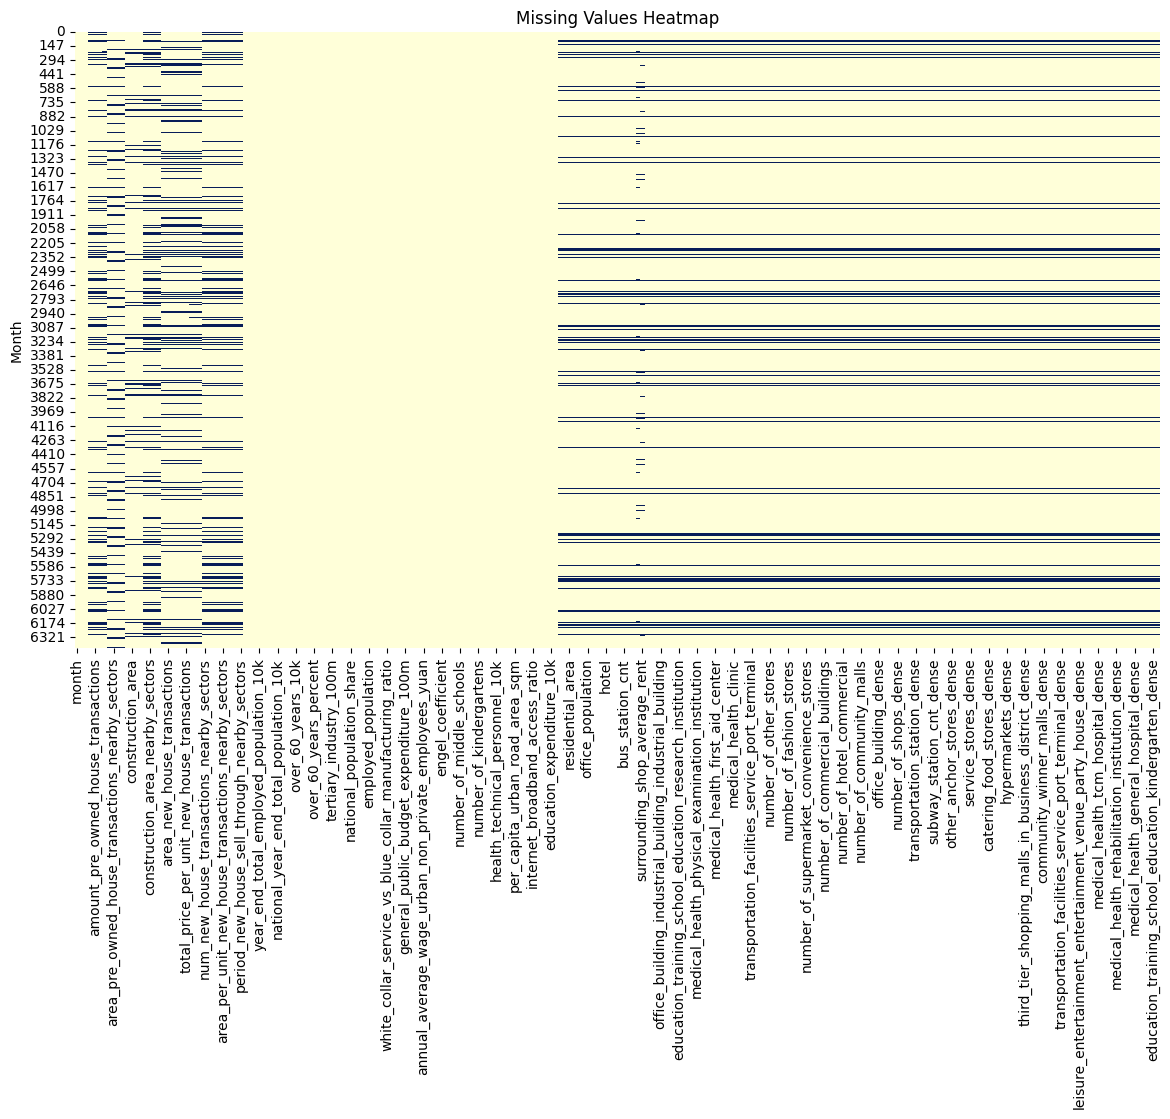

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制缺失值热力图
plt.figure(figsize=(14, 8))
sns.heatmap(df.isna(), cbar=False, cmap="YlGnBu")
plt.ylabel("Month")
plt.title("Missing Values Heatmap")
plt.show()

In [227]:
df = df.ffill()

In [231]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# 假设 df 已经是纯数值型且无缺失值
# X = df.values  # 或者 df.to_numpy()
numeric_df = df.select_dtypes(include=['int64', 'float64'])
X = numeric_df.values

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA，保留95%方差
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("原始特征数量:", X.shape[1])
print("PCA后特征数量:", X_pca.shape[1])

# 可选：查看各主成分贡献的方差比例
print("各主成分方差比例:", pca.explained_variance_ratio_)
print("累计方差比例:", pca.explained_variance_ratio_.cumsum())

原始特征数量: 237
PCA后特征数量: 31
各主成分方差比例: [0.22755121 0.18838575 0.10714923 0.07569824 0.0404655  0.02861179
 0.02771463 0.02307449 0.02143325 0.01988865 0.01790102 0.01623583
 0.01503448 0.01467112 0.01264285 0.01191056 0.01084544 0.01028427
 0.0098223  0.00902331 0.00778276 0.00736148 0.00687512 0.00664481
 0.00595599 0.00547503 0.00490816 0.00478537 0.00428661 0.00408247
 0.00385893]
累计方差比例: [0.22755121 0.41593696 0.52308619 0.59878443 0.63924993 0.66786172
 0.69557635 0.71865083 0.74008408 0.75997274 0.77787375 0.79410958
 0.80914406 0.82381518 0.83645803 0.84836859 0.85921403 0.8694983
 0.87932059 0.8883439  0.89612666 0.90348814 0.91036326 0.91700806
 0.92296406 0.92843909 0.93334725 0.93813262 0.94241923 0.9465017
 0.95036063]


Top 20 features correlated with the target:
amount_new_house_transactions                         1.000000
amount_new_house_transactions_nh                      0.867090
area_new_house_transactions                           0.770314
num_new_house_transactions                            0.747769
area_pre_owned_house_transactions                     0.466748
area_new_house_available_for_sale                     0.464528
num_pre_owned_house_transactions                      0.463230
num_new_house_available_for_sale                      0.461217
amount_pre_owned_house_transactions                   0.373181
number_of_residential_commercial                      0.350160
number_of_hypermarkets                                0.344586
number_of_leisure_and_entertainment_stores            0.316095
number_of_unranked_malls                              0.292685
number_of_shopping_centers                            0.289331
amount_new_house_transactions_nearby_sectors          0.230532
number_of_o

/var/folders/55/d2w0pl9d75786nm3jtbq0cdm0000gn/T/ipykernel_29074/1115181759.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target[top_features].values, y=top_features, palette="viridis")


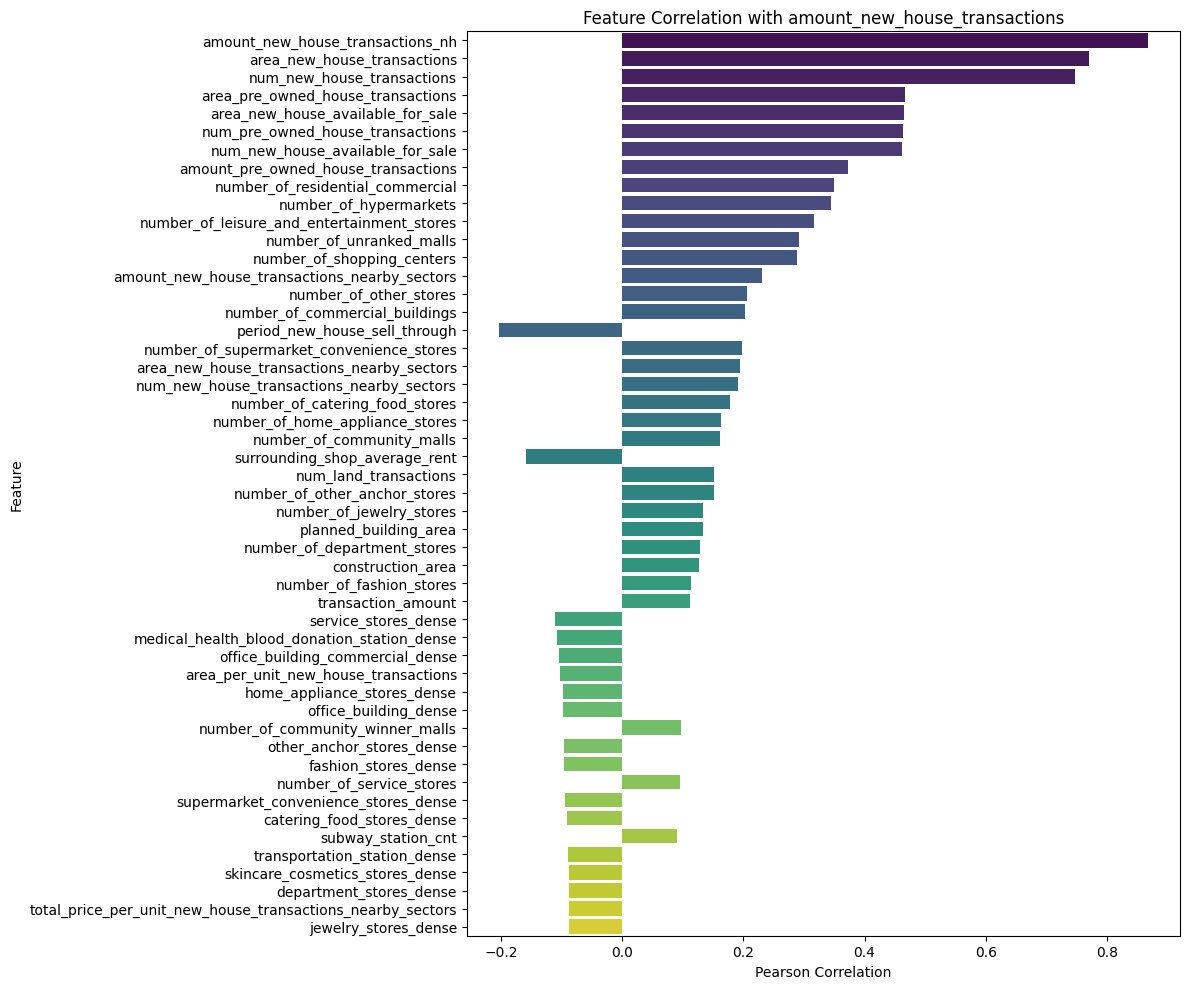

In [236]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame including the target column
target = 'amount_new_house_transactions'

# Compute correlation of each feature with the target
corr_with_target = df.corr()[target].sort_values(ascending=False)

# Print top 20 features by correlation
print("Top 20 features correlated with the target:")
print(corr_with_target.head(50))

# Visualize top 30 correlated features
top_features = corr_with_target.drop(target).abs().sort_values(ascending=False).head(50).index

plt.figure(figsize=(12,10))
sns.barplot(x=corr_with_target[top_features].values, y=top_features, palette="viridis")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")
plt.title("Feature Correlation with amount_new_house_transactions")
plt.tight_layout()
plt.show()